https://www.kaggle.com/code/manovirat/timeseries-using-prophet-hyperparameter-tuning

In [71]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.model_selection import ParameterGrid
from prophet.diagnostics import performance_metrics
import random
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

In [72]:
#Define MASE Metric
def mean_absolute_scaled_error(y_true, y_pred):
    mase=0
    # Define numerator as the forecast error
    numerator = (np.abs(y_true - y_pred))

    # Define denominator as the mean absolute error of the in-sample one-step naive forecast
    y_true_ohne_1 = y_true[1:].reset_index(drop=True)
    y_true_ohne_ende = y_true[:-1].reset_index(drop=True)
    denominator = np.mean(np.abs(y_true_ohne_1 - y_true_ohne_ende))

    mase = np.mean(np.abs(numerator / denominator))

    return mase

In [73]:
# Load the data
data = pd.read_parquet('/Users/paddy/Documents/GitHub/Masterthesis_ML/data/03_032022_032023_taxi_rides.parquet')

#load testset
test = pd.read_parquet('/Users/paddy/Documents/GitHub/Masterthesis_ML/data/03_60min_testset.parquet')

# Convert the date column to datetime
data['date'] = pd.to_datetime(data['date'],format='%d/%m/%y %H:%M:%S').dt.strftime('%Y-%m-%d %H:%M:%S') 
test['date'] = pd.to_datetime(test['date'],format='%d/%m/%y %H:%M:%S').dt.strftime('%Y-%m-%d %H:%M:%S') 


In [74]:
# Feature Engineering

# Add a column with the time
data['time'] = [x for x in range(0, len(data))]

# Create the lagged features 24 +1
lags = 25

# Create the lagged features
for i in range(1, lags):
    data['lag' + str(i)] = data['count'].shift(i)

# Drop the first three rows
data = data.dropna().reset_index(drop=True)

# Rename column count to y
data = data.rename(columns={'count': 'y'})
data = data.rename(columns={'date': 'ds'})


train_data = data

In [75]:
# #make features for testset
# test['time'] = [x for x in range(0, len(test))]
# for i in range(1, lags):
#     test['lag' + str(i)] = test['count'].shift(i)
# test = test.dropna().reset_index(drop=True)
test = test.rename(columns={'count': 'y'})
test = test.rename(columns={'date': 'ds'})


In [76]:
cv_folds = TimeSeriesSplit(n_splits=5)

#convert data to only date not time
cv_data = train_data.copy()

#convert to timestamp with date format
#cv_data.ds = pd.to_datetime(cv_data.ds).dt.date

print(cv_data.ds)   

#Define cutoff dates for cross validation at end of train_data/cv_folds
cutoffs = []
# for train_index, test_index in cv_folds.split(train_data):
#     cutoffs.append(train_data.ds.iloc[test_index].max())
#     #convert to timestamp
#     cutoffs = pd.to_datetime(cutoffs)
    
# print(cutoffs)

for i, (train_index, test_index) in enumerate(cv_folds.split(cv_data)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    #get the date for the last train index
    cutoffs.append(cv_data.ds.iloc[train_index].max())
    #only date not time
    #cutoffs = pd.to_datetime(cutoffs).date

print(cutoffs)

# Define cutoffs for cross validation with 5 folds every two months with first cut on 2022-06-01, last day 2023-01-15 and horizon of 15 days
#cutoffs = pd.to_datetime(['2022-06-01', '2022-08-01', '2022-10-01', '2022-12-01', '2023-01-15'])
# print(cutoffs)


0       2022-04-02 00:00:00
1       2022-04-02 01:00:00
2       2022-04-02 02:00:00
3       2022-04-02 03:00:00
4       2022-04-02 04:00:00
               ...         
9451    2023-04-30 19:00:00
9452    2023-04-30 20:00:00
9453    2023-04-30 21:00:00
9454    2023-04-30 22:00:00
9455    2023-04-30 23:00:00
Name: ds, Length: 9456, dtype: object
Fold 0:
  Train: index=[   0    1    2 ... 1573 1574 1575]
  Test:  index=[1576 1577 1578 ... 3149 3150 3151]
Fold 1:
  Train: index=[   0    1    2 ... 3149 3150 3151]
  Test:  index=[3152 3153 3154 ... 4725 4726 4727]
Fold 2:
  Train: index=[   0    1    2 ... 4725 4726 4727]
  Test:  index=[4728 4729 4730 ... 6301 6302 6303]
Fold 3:
  Train: index=[   0    1    2 ... 6301 6302 6303]
  Test:  index=[6304 6305 6306 ... 7877 7878 7879]
Fold 4:
  Train: index=[   0    1    2 ... 7877 7878 7879]
  Test:  index=[7880 7881 7882 ... 9453 9454 9455]
['2022-06-06 15:00:00', '2022-08-11 07:00:00', '2022-10-15 23:00:00', '2022-12-20 15:00:00', '2023-02-24

In [77]:

train = pd.DataFrame(train_data)
random.seed(0)
train_model =Prophet(changepoint_prior_scale = 0.001,
                    holidays_prior_scale = 5,
                    seasonality_prior_scale = 7.51,
                    seasonality_mode = 'additive',
                    weekly_seasonality=True,
                    daily_seasonality = True,
                    yearly_seasonality = False,
                    )

    # add regressors with lags 1 to 24
for i in range(1,25):
    train_model.add_regressor('lag'+str(i), standardize=False)
    train['lag'+str(i)] = train['y'].shift(i)


train_model.fit(train_data)

df_cv = cross_validation(train_model, period='60 days', horizon='30 days', parallel="processes")

    # X and y to pandas dataframe
X_train = pd.DataFrame(df_cv)

y_true = df_cv['y'].values
#make y_true as dataframe
y_true = pd.DataFrame(y_true)

y_pred = df_cv['yhat'].values
#make y_pred as dataframe
y_pred = pd.DataFrame(y_pred)


13:53:01 - cmdstanpy - INFO - Chain [1] start processing
13:53:04 - cmdstanpy - INFO - Chain [1] done processing
13:53:06 - cmdstanpy - INFO - Chain [1] start processing
13:53:06 - cmdstanpy - INFO - Chain [1] start processing
13:53:06 - cmdstanpy - INFO - Chain [1] start processing
13:53:06 - cmdstanpy - INFO - Chain [1] done processing
13:53:06 - cmdstanpy - INFO - Chain [1] start processing
13:53:06 - cmdstanpy - INFO - Chain [1] start processing
13:53:07 - cmdstanpy - INFO - Chain [1] done processing
13:53:08 - cmdstanpy - INFO - Chain [1] done processing
13:53:08 - cmdstanpy - INFO - Chain [1] done processing
13:53:09 - cmdstanpy - INFO - Chain [1] done processing


In [78]:
# make prediction
forecast = train_model.predict()

In [79]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

                      ds       yhat  yhat_lower  yhat_upper
9451 2023-04-30 19:00:00  20.236927   10.362015   30.778869
9452 2023-04-30 20:00:00  27.127055   16.354509   37.440141
9453 2023-04-30 21:00:00  25.905766   16.340993   35.879701
9454 2023-04-30 22:00:00  31.588589   21.472763   42.255604
9455 2023-04-30 23:00:00  39.573410   29.216124   49.847187


In [80]:
#calculate mase
MASE_pred = mean_absolute_scaled_error(test['y'], forecast['yhat'])
#round to 4 digits
MASE_pred = round(MASE_pred, 4)
print(MASE_pred)

0.845


In [81]:
MASE_list = []
for i in range(0, len(test), 24):
    MASE_pred = mean_absolute_scaled_error(test['y'][i:i+24], forecast['yhat'][i:i+24])
    MASE_list.append(MASE_pred)

print(MASE_list)

[0.8977732827186174, 0.9078590087075445, 0.7948344192596822, 0.759369669848366, 0.8562062610698175, 0.9446051913505894, 0.58662548439166, 0.9111064486443582, 1.0495283243062479, 0.981927207602625, 0.7734055010590343, 0.8580526995211448, 0.9225515556129361, 0.7738977797943035, 0.6580505612755035, 1.2533848645526444, 1.1457811657580255, 1.2060620446184946, 0.8795453653769941, 0.610611859797353, 0.8912591633383945, 1.7286005989514397, 0.7908737629538837, 0.8382361627821556, 0.8695781088133203, 0.8798670892016709, 0.8914139604173253, 0.796508118357635, 1.0093304781228902]


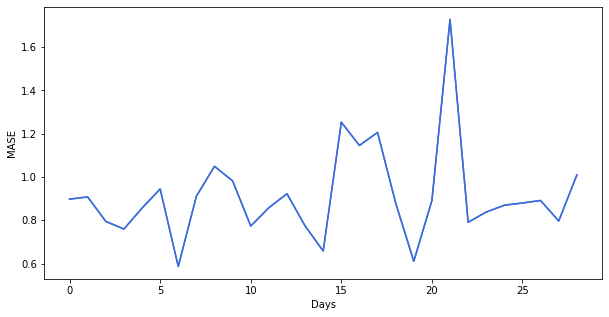

In [88]:
#plot the list of MASE values with days
import matplotlib.pyplot as plt
plt.plot(MASE_list)
plt.ylabel('MASE')
plt.xlabel('Days')

#make plot royalblue
plt.plot(MASE_list, color='royalblue')
#make plot smaller

#save plot
plt.savefig('/Users/paddy/Documents/GitHub/Masterthesis_ML/plots/MASE_verlauf.png', bbox_inches='tight')

plt.rcParams["figure.figsize"] = (10,5)
plt.show()

In [83]:
#save the forecast
forecast.to_parquet('/Users/paddy/Documents/GitHub/Masterthesis_ML/data/03_60min_lagged_prophet_forecast.parquet')

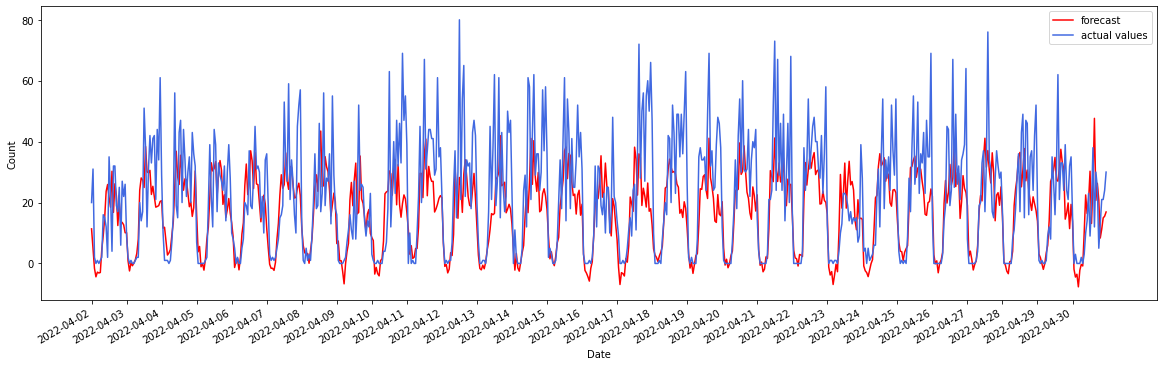

In [103]:
#plot only the forecast for 24 hours and the actual values

import matplotlib.pyplot as plt
#plot the forecast for 24 hours with color red
plt.plot(forecast['yhat'][0:len(test)], color='red')
plt.plot(test['y'][0:len(test)], color='royalblue')

#make x axis from forecast['ds'] without time
forecast['ds'] = pd.to_datetime(forecast['ds'],format='ISO8601').dt.strftime('%Y-%m-%d')
plt.xticks(np.arange(0, len(test), step=24), forecast['ds'][0:len(test):24], rotation=90)
plt.xlabel('Date')
#make the x axis format date without time
plt.gcf().autofmt_xdate()

#show legend
plt.legend(['forecast', 'actual values'])

#make plot wider
plt.rcParams["figure.figsize"] = (20,6)

plt.ylabel('Count')

#save the plot
plt.savefig('/Users/paddy/Documents/GitHub/Masterthesis_ML/plots/03_60min_lagged_prophet_forecast.png', bbox_inches='tight')
